  Model1    Model2  DM Statistic       p-value
0    SVR      LSTM     10.820421  0.000000e+00
1    SVR       CNN     10.833595  0.000000e+00
2    SVR  CNN-LSTM     11.101278  0.000000e+00
3   LSTM       CNN      6.295331  3.067446e-10
4   LSTM  CNN-LSTM     10.522663  0.000000e+00
5    CNN  CNN-LSTM      7.408487  1.276756e-13


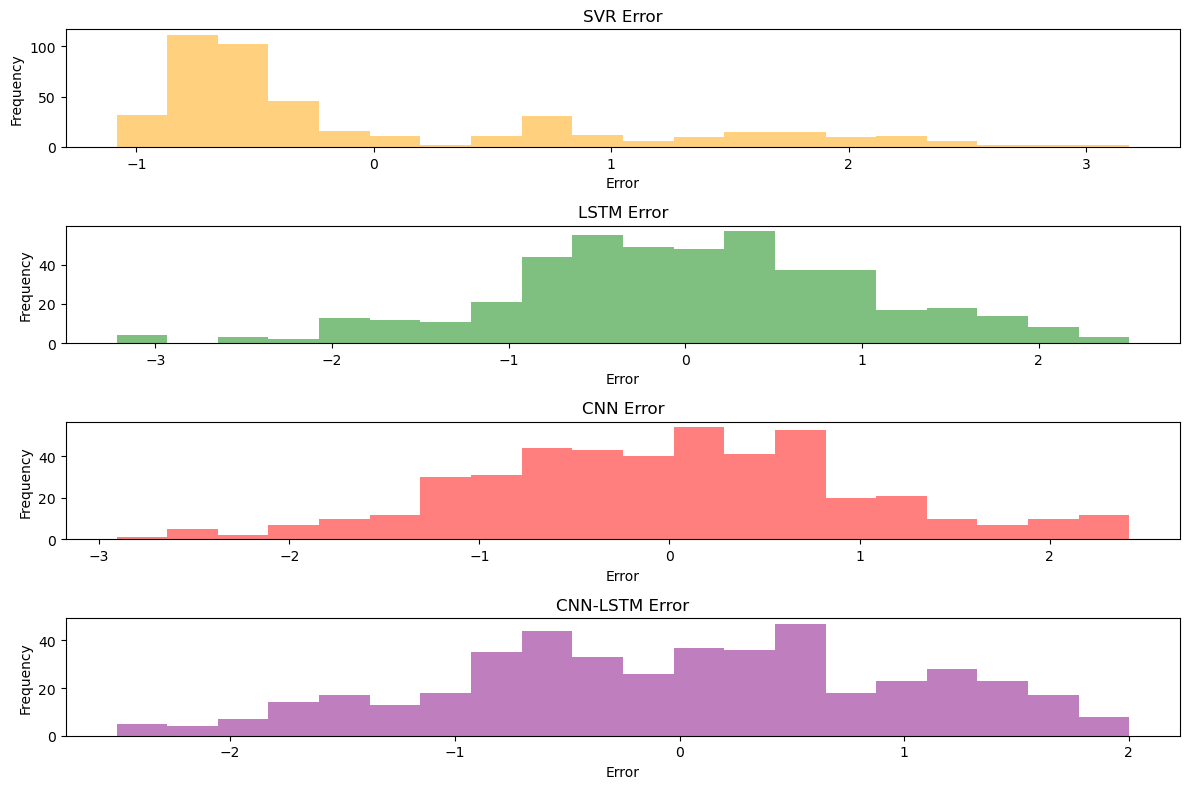

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from itertools import combinations

# 读取模型的预测结果
model_svr_test_predictions = pd.read_csv('modelSVR_test_predictions.csv')
model_lstm_test_predictions = pd.read_csv('modelLSTM_test_predictions.csv')
model_cnn_test_predictions = pd.read_csv('modelCNN_test_predictions.csv')
model_cnn_lstm_test_predictions = pd.read_csv('modelCNN-LSTM_test_predictions.csv')

# 确保所有模型的预测结果长度相同
min_length = min(len(model_svr_test_predictions), 
                 len(model_lstm_test_predictions), 
                 len(model_cnn_test_predictions), 
                 len(model_cnn_lstm_test_predictions))

# 截取最小长度的数据
model_svr_test_predictions = model_svr_test_predictions.iloc[:min_length]
model_lstm_test_predictions = model_lstm_test_predictions.iloc[:min_length]
model_cnn_test_predictions = model_cnn_test_predictions.iloc[:min_length]
model_cnn_lstm_test_predictions = model_cnn_lstm_test_predictions.iloc[:min_length]


# 提取实际值和预测值
y_test_svr = model_svr_test_predictions['Actual'].values
y_pred_svr = model_svr_test_predictions['Prediction'].values
y_pred_lstm = model_lstm_test_predictions['Prediction'].values
y_pred_cnn = model_cnn_test_predictions['Prediction'].values
y_pred_cnn_lstm = model_cnn_lstm_test_predictions['Prediction'].values


# 确保只有ARIMA模型的实际值与其他模型的实际值不一样
assert np.array_equal(y_test_svr, model_lstm_test_predictions['Actual'].values)
assert np.array_equal(y_test_svr, model_cnn_test_predictions['Actual'].values)
assert np.array_equal(y_test_svr, model_cnn_lstm_test_predictions['Actual'].values)

# 使用SVR模型的实际值作为基准实际值
y_test = y_test_svr

# 模型预测结果列表（排除ARIMA模型）
predictions = {
    'SVR': y_pred_svr,
    'LSTM': y_pred_lstm,
    'CNN': y_pred_cnn,
    'CNN-LSTM': y_pred_cnn_lstm
}

# 计算误差
errors = {model: y_test - pred for model, pred in predictions.items()}

# 对误差进行标准化处理
scaler = StandardScaler()
standardized_errors = {model: scaler.fit_transform(error.reshape(-1, 1)).flatten() for model, error in errors.items()}

# Diebold-Mariano 测试函数
def diebold_mariano_test(y_true, y_pred1, y_pred2, h=1, crit='MSE'):
    e1 = y_true - y_pred1
    e2 = y_true - y_pred2

    if crit == 'MSE':
        d = e1**2 - e2**2
    elif crit == 'MAE':
        d = np.abs(e1) - np.abs(e2)
    else:
        raise ValueError('crit should be "MSE" or "MAE"')

    mean_d = np.mean(d)
    var_d = np.var(d, ddof=1)

    # 自相关修正
    adj_factor = 1 + 2 * sum([np.corrcoef(d[:-i], d[i:])[0, 1] for i in range(1, h)])
    dm_stat = mean_d / np.sqrt((var_d / len(d)) * adj_factor)

    p_value = 2 * (1 - stats.norm.cdf(np.abs(dm_stat)))

    return dm_stat, p_value

# 自动生成所有可能的模型对（排除ARIMA模型）
model_pairs_to_compare = list(combinations(predictions.keys(), 2))

# 进行指定模型对的比较（排除ARIMA模型）
results = []
for model1, model2 in model_pairs_to_compare:
    y_pred1 = predictions[model1]
    y_pred2 = predictions[model2]
    dm_stat, p_value = diebold_mariano_test(y_test, y_pred1, y_pred2)
    results.append((model1, model2, dm_stat, p_value))

# 将结果转换为DataFrame并展示
results_df = pd.DataFrame(results, columns=['Model1', 'Model2', 'DM Statistic', 'p-value'])
print(results_df)

# 分别绘制各模型的预测误差直方图（排除ARIMA模型）
colors = ['orange', 'green', 'red', 'purple']
fig, axs = plt.subplots(len(predictions), 1, figsize=(12, 8))

for ax, (model, error), color in zip(axs, standardized_errors.items(), colors):
    ax.hist(error, bins=20, alpha=0.5, color=color)
    ax.set_title(f'{model} Error')
    ax.set_xlabel('Error')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()